<a href="https://colab.research.google.com/github/FbnLm/PUC/blob/main/MVP_Fabiano_Lima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Problema Proposto.

Este estudo visa prever o nível de obesidade de um indivíduo com base em algumas caracteríscticas físicas e comportamentais.


Será usado o médoto de classificação para determinar se as informaçoes fornecidas são suficientes para a definição do perfil analisado.


**DATASET utilizado:**  ObesityDataSet_raw_and_data_sinthetic

*(fonte: https://www.kaggle.com/datasets/fatemehmehrparvar/obesity-levels/download?datasetVersionNumber=1)*


In [183]:
# Imports necessários (bibliotecas e configurações)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #para particionar em base de treino e teste (holdout)
from sklearn.model_selection import KFold #para preparar os folds de validação cruzada
from sklearn.model_selection import cross_val_score #para executar a validação cruzada
from sklearn.metrics import accuracy_score #para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier #algorítimo KNN
from sklearn.tree import DecisionTreeClassifier #algorítimo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB #algorítimo Naive Bayes
from sklearn.svm import SVC #algorítimo SVM
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



### 2. Preparação de Dados.

In [184]:
# Carregando os dados
url = "https://raw.githubusercontent.com/FbnLm/PUC/main/ObesityDataSet_raw_and_data_sinthetic.csv"
tabela = pd.read_csv(url,delimiter=',')
dataset = pd.DataFrame(tabela).round() #faz o arredondamento dos valores numéricos da tabela.


Para a análise usaremos apenasas informações consideradas relevantes dentro do banco de dados.

In [185]:
# Criando uma database com seleção de atribjtos (deletando dados indesejados)
dataset_ds = dataset.drop(['SCC', 'family_history_with_overweight', 'TUE', 'CAEC', 'MTRANS'], axis = 1) #cria uma nova nova database excluindo as coluna especificadas.


Para os dados não númricos da tabela, faremos a conversão usando o OrdinalEncoder do sklearn.

In [186]:
# Convertendo os valores não númericos do dataset1

encoder_gender = OrdinalEncoder(categories=[['Male', 'Female']])
dataset_ds['Gender'] = encoder_gender.fit_transform(dataset_ds[['Gender']])

# Isolando variáveis contínuas
int_cols = dataset_ds.select_dtypes(include=['int64']).columns

#  Verificando a correlação das colunas flutuantes com a variável de destino
correlations = dataset_ds[int_cols].corrwith(dataset_ds['Gender'])[:-1].sort_values(ascending=False)

encoder_calc = OrdinalEncoder(categories=[['no', 'Sometimes', 'Frequently', 'Always']]) # Frequency of alcohol intake.
dataset_ds['CALC'] = encoder_calc.fit_transform(dataset_ds[['CALC']])

# Isolando variáveis contínuas
int_cols = dataset_ds.select_dtypes(include=['int64']).columns

#  Verificando a correlação das colunas flutuantes com a variável de destino
correlations = dataset_ds[int_cols].corrwith(dataset_ds['CALC'])[:-1].sort_values(ascending=False)

encoder_favc = OrdinalEncoder(categories=[['yes', 'no']]) # Consume high-calorie foods frequently
dataset_ds['FAVC'] = encoder_favc.fit_transform(dataset_ds[['FAVC']])

# Isolando variáveis contínuas
int_cols = dataset_ds.select_dtypes(include=['int64']).columns

#  Verificando a correlação das colunas flutuantes com a variável de destino
correlations = dataset_ds[int_cols].corrwith(dataset_ds['FAVC'])[:-1].sort_values(ascending=False)

encoder_smoke = OrdinalEncoder(categories=[['yes', 'no']]) # fumante
dataset_ds['SMOKE'] = encoder_smoke.fit_transform(dataset_ds[['SMOKE']])

# Isolando variáveis contínuas
int_cols = dataset_ds.select_dtypes(include=['int64']).columns

#  Verificando a correlação das colunas flutuantes com a variável de destino
correlations = dataset_ds[int_cols].corrwith(dataset_ds['SMOKE'])[:-1].sort_values(ascending=False)

encoder_nobd = OrdinalEncoder(categories=[['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']]) # Body mass index
dataset_ds['NObeyesdad'] = encoder_nobd.fit_transform(dataset_ds[['NObeyesdad']])

# Isolando variáveis contínuas
int_cols = dataset_ds.select_dtypes(include=['int64']).columns

#  Verificando a correlação das colunas flutuantes com a variável de destino
correlations = dataset_ds[int_cols].corrwith(dataset_ds['NObeyesdad'])[:-1].sort_values(ascending=False)


### 3. Análise Preliminar.

Visualizando caractrísticas do dataset.

In [187]:
# Resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset_ds.describe()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SMOKE,CH2O,FAF,NObeyesdad
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.315964,0.494079,1.995737,86.586452,0.731407,0.116059,2.423496,2.687826,0.979157,2.014685,1.006632,3.112269
std,6.357078,0.500083,0.065171,26.190136,0.515498,0.320371,0.583905,0.809680,0.142893,0.688616,0.895462,1.985062
min,14.000000,0.000000,1.000000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,20.000000,0.000000,2.000000,65.500000,0.000000,0.000000,2.000000,3.000000,1.000000,2.000000,0.000000,1.000000
50%,23.000000,0.000000,2.000000,83.000000,1.000000,0.000000,2.000000,3.000000,1.000000,2.000000,1.000000,3.000000
75%,26.000000,1.000000,2.000000,107.000000,1.000000,0.000000,3.000000,3.000000,1.000000,2.000000,2.000000,5.000000
max,61.000000,1.000000,2.000000,173.000000,3.000000,1.000000,3.000000,4.000000,1.000000,3.000000,3.000000,6.000000


In [188]:
# Mostra as 5 primeiras e as 5 últimas linhas do dataset
display(dataset_ds)

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SMOKE,CH2O,FAF,NObeyesdad
0,21.0,1.0,2.0,64.0,0.0,1.0,2.0,3.0,1.0,2.0,0.0,1.0
1,21.0,1.0,2.0,56.0,1.0,1.0,3.0,3.0,0.0,3.0,3.0,1.0
2,23.0,0.0,2.0,77.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,1.0
3,27.0,0.0,2.0,87.0,2.0,1.0,3.0,3.0,1.0,2.0,2.0,2.0
4,22.0,0.0,2.0,90.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2106,21.0,1.0,2.0,131.0,1.0,0.0,3.0,3.0,1.0,2.0,2.0,6.0
2107,22.0,1.0,2.0,134.0,1.0,0.0,3.0,3.0,1.0,2.0,1.0,6.0
2108,23.0,1.0,2.0,134.0,1.0,0.0,3.0,3.0,1.0,2.0,1.0,6.0
2109,24.0,1.0,2.0,133.0,1.0,0.0,3.0,3.0,1.0,3.0,1.0,6.0


In [189]:
# Mostra as informações do dataset
print(dataset_ds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         2111 non-null   float64
 1   Gender      2111 non-null   float64
 2   Height      2111 non-null   float64
 3   Weight      2111 non-null   float64
 4   CALC        2111 non-null   float64
 5   FAVC        2111 non-null   float64
 6   FCVC        2111 non-null   float64
 7   NCP         2111 non-null   float64
 8   SMOKE       2111 non-null   float64
 9   CH2O        2111 non-null   float64
 10  FAF         2111 non-null   float64
 11  NObeyesdad  2111 non-null   float64
dtypes: float64(12)
memory usage: 198.0 KB
None


In [190]:
# Mostra as dimensões do dataset
print(dataset_ds.shape)

(2111, 12)


### 4. Operações.

In [191]:
# Preparação dos dados do dataset_ds

seed = 7 # semente aleatória

#Separação em bases de treino e teste(holdout) do dataset1
array = dataset_ds.values
X = array[:,0:11]
y = array[:,11]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30) #define a proporção de dados de treinamento (80%) e teste (20%).

#Criando os folds para a validação cruzada
num_part = 10
KFold = KFold(n_splits=num_part, shuffle=True, random_state=30)


### 5. Modelagem e Treinamento.

KNN: 0.847126 (0.020893)
CART: 0.866698 (0.021591)
NB: 0.589479 (0.031684)
SVM: 0.558104 (0.033120)
RF-orig: 0.899873 (0.011135)
ET-orig: 0.879117 (0.018789)


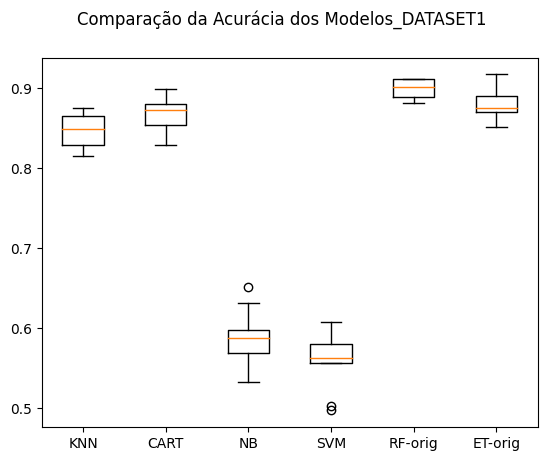

In [192]:
# Modelagem

# Definindo uma seed global para esta cédula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
pipelines = []
results = []
names = []

random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))

# Preparando os modelos e adicionando-os em uma lista
pipelines.append(('KNN', KNeighborsClassifier()))
pipelines.append(('CART', DecisionTreeClassifier()))
pipelines.append(('NB', GaussianNB()))
pipelines.append(('SVM', SVC()))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))

# Avaliando um modelo por vez
for name, model in pipelines:
  cv_results = cross_val_score(model, X_train, y_train, cv=KFold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

# Bloxolot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos_DATASET1')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### 6. Avaliação de Resultados.

In [193]:
# Criando um modelo com todo o conjunto de treino
model = GaussianNB()
model.fit(X_train, y_train)

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200)
model.fit(rescaledX, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando a acurácia no conjunto de teste
print("DATASET:", accuracy_score(y_test,predictions))

# Novos dados - não sabemos a classe!
data = {'Age':  [27.0, 33.0], 'Gender': [1.0, 0.0],
        'Height': [2.0, 2.0],
        'Weight': [72.5, 89.5],
        'CALC': [2.0, 1.0], 'FAVC': [2.0, 3.0], 'FCVC': [3.0, 2.0],
	'NPC': [2.0, 3.0], 'SMOKE': [2.0, 1.0], 'CH2O': [2.0, 3.0],
	'FAF': [0.0, 3.0],
        }

atributos = ['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NPC', 'SMOKE', 'CH2O', 'FAF']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

DATASET: 0.13711583924349882
[[ 0.42321669  1.02034918  0.06453052 -0.52974617  2.47403864  5.83637687
   0.9781154  -0.82333626  6.97934555 -0.02598771 -1.11844813]
 [ 1.3708927  -0.98005665  0.06453052  0.11779158  0.52801011  8.93735394
  -0.74532802  0.39471072  0.1497019   1.43625437  2.23490968]]
[3. 3.]


### 7. Montagem de Mapa de Correlação.

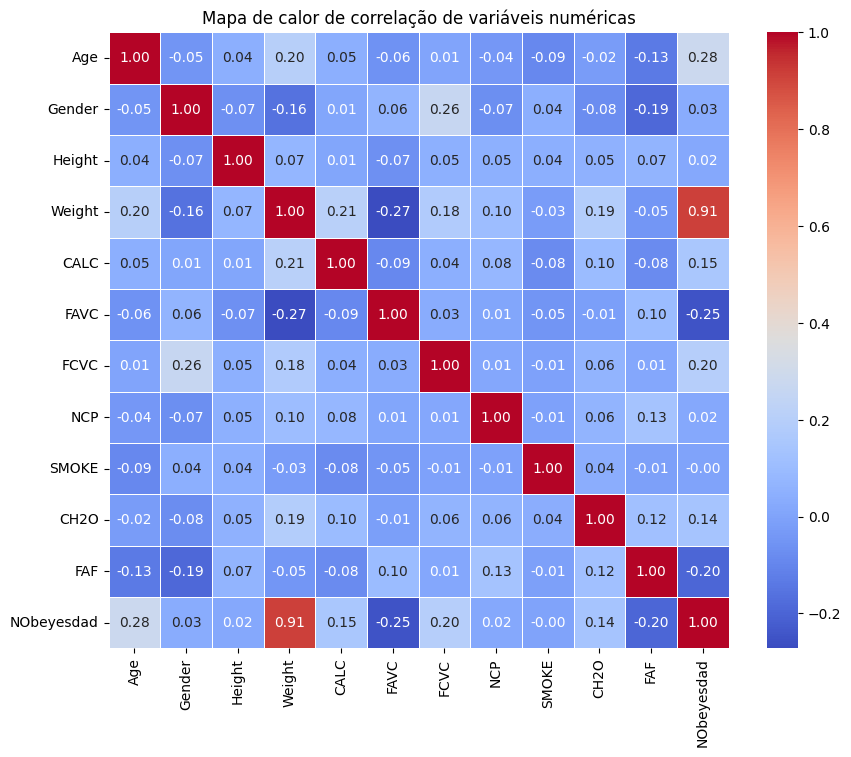

In [194]:
import seaborn as sns

numerical_cols = dataset_ds.select_dtypes(include='number')
correlation_matrix = numerical_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de calor de correlação de variáveis numéricas')
plt.show()